# Project 1 - Gradient Descent Methods
Natalie Pham

$\mathbf{Goal: }$ To solve the optimal control problem
$$ \min_{u \in L^2(\Omega)} J(Y,u) = \frac{1}{2} || y - y_d||^2 + \frac{\gamma}{2} || u ||^2$$
$$ \text{subject to } \begin{cases} -\Delta y = u , & \text{in } \Omega \\ y \big|_{\partial \Omega } = 0 ,& \text{on } \partial \Omega \end{cases}$$

Let $Su = y \Rightarrow f'(u) = S^*(Su - y_d) + \gamma u$, then we have the KKT system:
- State problem: 
$$ \begin{cases} -\Delta y = u , & \text{in } \Omega \\ y  = 0 ,& \text{on } \partial \Omega \end{cases}$$
- Adjoint problem:
$$ \begin{cases} -\Delta p = y - y_d , & \text{in } \Omega \\ p = 0 ,& \text{on } \partial \Omega \end{cases}$$
- Optimality condition: 
$$ p + \gamma u = 0$$

The report presents 3 optimization methods to solve this optimal control problem:
1. Steepest gradient descent with Amijo search for step-size $\alpha$
2. Steepest gradient descent with exact search for step-size $\alpha$
3. Conjugate gradient descent

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

In [2]:
# define objective function
f = lambda u, Yi, yd, gamma: 1/2 * np.linalg.norm(Yi - yd)**2 + gamma/2 * np.linalg.norm(u)**2

In [3]:
def Poisson2DCode1(xl, xr, yb, yt, h, b):
    """
    Finite difference method to solve the Poisson equation. 
    
    :param xl: left boundary
    :param xr: right boundary
    :param yb: bottom boundary
    :param yt: top boundary
    :param b: right-handside vector of the Poisson equation
    :return: mesh solution of the Poisson equation
    """
    
    N = int((xr - xl) / h)
    x = np.linspace(xl, xr, N+1)
    y = np.linspace(yb, yt, N+1)
    A = np.zeros(((N+1)**2, (N+1)**2))
    for i in range(1, N):
        for j in range(1, N):
            A[i + j*(N+1), i - 1 + j*(N+1)] = 1/h**2
            A[i + j*(N+1), i + 1 + j*(N+1)] = 1/h**2
            A[i + j*(N+1), i + j*(N+1)] = -4/h**2
            A[i + j*(N+1), i + (j - 1)*(N+1)] = 1/h**2
            A[i + j*(N+1), i + (j + 1)*(N+1)] = 1/h**2
            
    for i in range(N+1):
        j = 0
        p = i + j*(N+1)
        #A[p, :] = 0
        A[p, p] = 1
        b[p] = 0
        j = N
        q = i + j*(N+1)
        #A[q, :] = 0
        A[q, q] = 1
        b[q] = 0
    for j in range(N+1):
        i = 0
        p = i + j*(N+1)
        #A[p, :] = 0
        A[p, p] = 1
        b[p] = 0
        i = N
        q = i + j*(N+1)
        #A[q, :] = 0
        A[q, q] = 1
        b[q] = 0
    
    #print(A)
    v = np.linalg.solve(A, b)
    w = np.reshape(v[0:(N+1)**2], (N+1, N+1)).reshape(-1, 1) 
    
    return w

In [4]:
def Poisson2DCode2(xl, xr, yb, yt, h, b):
    """
    Finite difference method to solve the Poisson equation. 
    
    :param xl: left boundary
    :param xr: right boundary
    :param yb: bottom boundary
    :param yt: top boundary
    :param b: right-handside vector of the Poisson equation
    :return: mesh solution of the Poisson equation, matrix A used to solve the Poisson equation
    """

    N = int((xr - xl)/h)
    # setup mesh values
    x = np.linspace(xl, xr, N+1)
    y = np.linspace(yb, yt, N+1)
    
    I = np.eye(N+1)
    e = np.ones(N+1)
    T = np.diag(e[1:], -1) + np.diag(-4*e) + np.diag(e[1:], 1)
    S = np.diag(e[1:], 1) + np.diag(e[1:], -1)
    A = (np.kron(I,T) + np.kron(S,I))/h**2

    for i in range(N+1):
        j = 0
        p = i + j*(N+1)
        A[p, :] = 0
        A[p, p] = 1
        b[p] = 0
        j = N
        q = i + j*(N+1)
        A[q, :] = 0
        A[q, q] = 1
        b[q] = 0
    for j in range(N+1):
        i = 0
        p = i + j*(N+1)
        A[p, :] = 0
        A[p, p] = 1
        b[p] = 0
        i = N
        q = i + j*(N+1)
        A[q, :] = 0
        A[q, q] = 1
        b[q] = 0
        
    # solve for solution in v labeling
    v = np.linalg.solve(-A, b) 
    #print(A)
    
    # translate from v to w
    w = np.reshape(v[0:(N+1)**2], (N+1, N+1)).reshape(-1, 1) 
    
    return w, A

In [5]:
# Initialize starting condition
xl = 0
xr = 1
yb = 0
yt = 1
h = 0.01 
N = int((xr - xl) / h)
gamma = 10**(-6)

# Initialize maxinum number of iteration to run the algorithms
max_iter = 500

### 1. Gradient Descent with Armijo search

$\mathbf{Algorithm:}$
- Initialize $u_0$, k = 0
- While the residual greater than the tolerance or max iteration not yet reached:
    - Solve the state equation to get $y_k$
    - Solve the dual equation to get $p_k$
    - Compute the gradient $\nabla f(u_k) = p_k + \gamma u_k$
    - Compute the step size $\alpha_k$ using the Armijo condition
    - Update $u_{k+1} = u_k + \alpha_k \nabla f(u_k)$
    - Increment the iteration $k = k+1$

In [6]:
def armijo_search(f, x, d, c=10^(-4), alpha=100.0):
    """
    Armijo search algorithm for finding the step size that satisfies the Armijo condition in the given direction.

    :param f: Function to optimize
    :param x: Current point
    :param d: Search direction
    :param c: Constant for the Armijo condition
    :param alpha: Initial step size. Default is 1.0.
    :return: Step size that satisfies the Armijo condition.
    """
    while float(f(x + alpha * d, Yi, yd, gamma)) > float(f(x, Yi, yd, gamma) - c * alpha *np.matmul(d.T,d)):
        alpha = alpha / 2.0
    return alpha

In [7]:
u = np.zeros(((N+1)**2,1))
x = np.linspace(xl, xr, N+1)
y = np.linspace(yb, yt, N+1)
X, Y = np.meshgrid(x, y)
yde = X*Y*(X-1)*(Y-1) 
yd = yde.reshape(-1,1)
residual = 1 
tol = 10**(-6) 
iteration = 1 
Yi,_ = Poisson2DCode2(xl,xr,yb,yt,h,u)
P,_ = Poisson2DCode2(xl,xr,yb,yt,h,Yi-yd)
gradient = P + gamma*u

In [8]:
start = time.time()
for iteration in tqdm(range(max_iter)):
    d = - gradient
    alpha = armijo_search(f, u, d)
    u = u + alpha*d
    Yi,_ = Poisson2DCode2(xl,xr,yb,yt,h,u)
    P,_ = Poisson2DCode2(xl,xr,yb,yt,h,Yi-yd)
    gradient = P + gamma*u
    residual = h*np.linalg.norm(gradient)
    if residual < tol:
        break

end = time.time()
print('Time taken: ', end-start)

 69%|████████████████████████████████████████████████████▍                       | 345/500 [4:01:30<1:48:30, 42.00s/it]

Time taken:  14490.128648281097


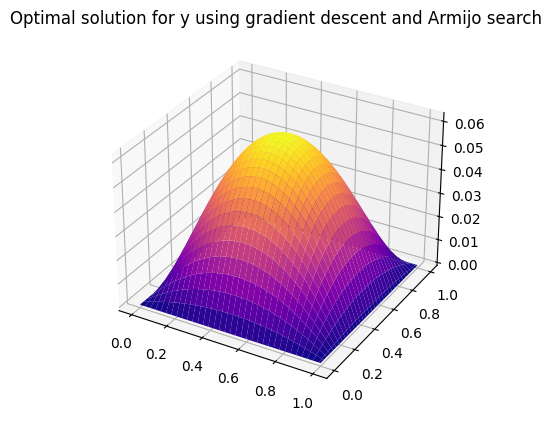

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Yi.reshape(N+1,N+1), cmap='plasma')
ax.set_title('Optimal solution for y using gradient descent and Armijo search')
#  plt.savefig('amijo_gd_y.png')
plt.show()

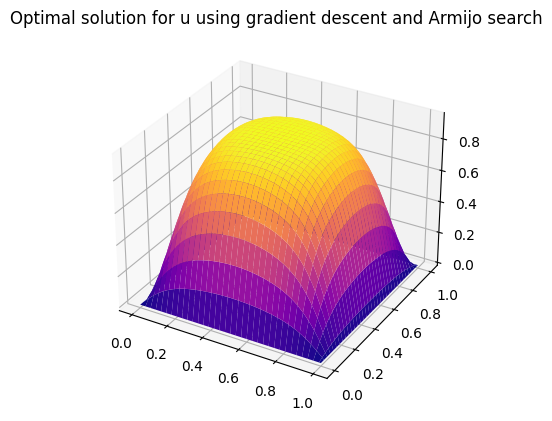

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, u.reshape(N+1,N+1), cmap='plasma')
ax.set_title('Optimal solution for u using gradient descent and Armijo search')
# plt.savefig('amijo_gd_u.png')
plt.show()

In [11]:
print(iteration,residual)

345 9.99598665407829e-07


### 2. Gradient Descent with exact search

Compute $\alpha_k$ using the exact search method:
$$ \alpha_k = \frac{d_k^T.d_k}{d_k^T.Q.d_k} = \frac{d_k^T.d_k}{(d_k.A^{-1})^T(d_k.A^{-1}) + \gamma d_k^T.d_k}$$
where $d_k = - \nabla f(u_k), A_k$ is the matrix to solve the Poisson equation involving $y_k$.

$\mathbf{Algorithm:}$
- Initialize $u_0$, k = 0
- While the residual greater than the tolerance or max iteration not yet reached:
    - Solve the state equation to get $y_k$
    - Solve the dual equation to get $p_k$
    - Compute the gradient $\nabla f(u_k) = p_k + \gamma u_k$
    - Compute the step size $\alpha_k$ using exact search
    - Update $u_{k+1} = u_k + \alpha_k \nabla f(u_k)$
    - Increment the iteration $k = k+1$

In [12]:
def exact_search(d, A, gamma):
    """
    exact search algorithm for finding the step size alpha.

    :param d: Search direction (- gradient)
    :param A: Matrix to solve the Poisson equation involving y
    :param gamma: Value of gamma in the objective function
    :return: Step size that compute using exact search method.
    """
    dd = np.matmul(d.T,d)
    A_inv = np.linalg.inv(A)
    dA = np.matmul(A_inv,d)
    denominator = np.matmul(dA.T,dA) + gamma*dd
    alpha = dd / denominator
    return alpha

In [13]:
u = np.zeros(((N+1)**2,1))
x = np.linspace(xl, xr, N+1)
y = np.linspace(yb, yt, N+1)
X, Y = np.meshgrid(x, y)
yde = X*Y*(X-1)*(Y-1) 
yd = yde.reshape(-1,1)
residual = 1 
tol = 10**(-6) 
iteration = 1 
Yi, A = Poisson2DCode2(xl,xr,yb,yt,h,u)
P,_ = Poisson2DCode2(xl,xr,yb,yt,h,Yi-yd)
gradient = P + gamma*u
#alpha = exact_search(-gradient, A, gamma)

In [14]:
start = time.time()
for iteration in tqdm(range(max_iter)):
    d = - gradient
    alpha = exact_search(d, A, gamma)
    # print(alpha)
    u = u + alpha*d
    Yi, A = Poisson2DCode2(xl,xr,yb,yt,h,u)
    P,_ = Poisson2DCode2(xl,xr,yb,yt,h,Yi-yd)
    gradient = P + gamma*u
    residual = h*np.linalg.norm(gradient)
    if residual < tol:
        break

end = time.time()
print('Time taken: ', end-start)

  2%|█▌                                                                            | 10/500 [14:40<11:58:45, 88.01s/it]

Time taken:  880.2146592140198


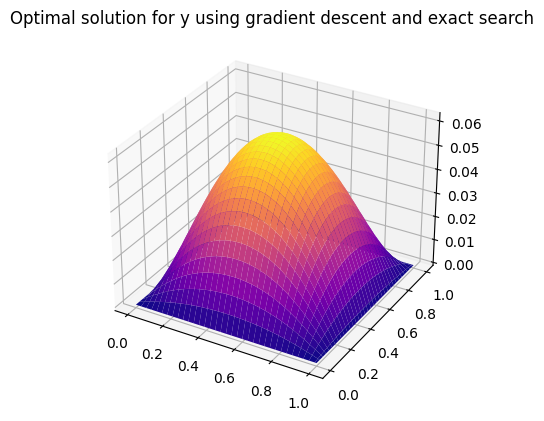

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Yi.reshape(N+1,N+1), cmap='plasma')
ax.set_title('Optimal solution for y using gradient descent and exact search')
plt.savefig('exact_gd_y.png')
plt.show()

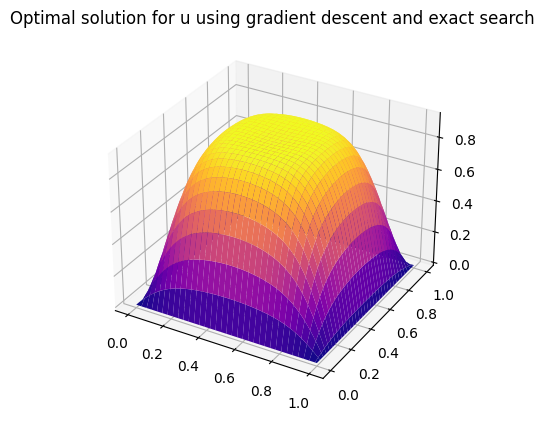

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, u.reshape(N+1,N+1), cmap='plasma')
ax.set_title('Optimal solution for u using gradient descent and exact search')
plt.savefig('exact_gd_u.png')
plt.show()

In [17]:
print(iteration,residual)

10 9.623683374002465e-07


### 3. Conjugate Gradient Descent

$\mathbf{Algorithm:}$
- Initialize $u_0$, k = 0
- Compute $r_0 = p_0 = -\gamma u_0 - S^*(Su_0 - y_d)$
- While the residual greater than the tolerance or max iteration not yet reached:
    - Compute $Ap_k = \gamma p_k + S^*(Sp_k)$
    - Compute the step size $\alpha_k = \frac{(r_k,r_k)}{(Ap_k,p_k)}$
    - Update $u_{k+1} = u_k + \alpha_k p_k$
    - Update $r_{k+1} = r_k - \alpha_k Ap_k$
    - Compute $\beta_k = \frac{(r_{k+1},r_{k+1})}{(r_k,r_k)}$
    - Update the gradient $p_{k+1} = r_k + \beta p_k$
    - Increment the iteration $k = k+1$
    
where $r_k  = -\gamma u_k - S^*(Su_k - y_d)$,  $ p_k = - \nabla f(u_k)$, and $\{ p_0, p_1, \dots, p_k \} $ linearly independent and orthogonal.

In [18]:
u = np.zeros(((N+1)**2,1))
x = np.linspace(xl, xr, N+1)
y = np.linspace(yb, yt, N+1)
X, Y = np.meshgrid(x, y)
yde = X*Y*(X-1)*(Y-1) 
yd = yde.reshape(-1,1)
residual = 1 
tol = 10**(-6) 
y = Poisson2DCode1(xl,xr,yb,yt,h,u)
y = y.reshape(-1,1)
Z = Poisson2DCode1(xl,xr,yb,yt,h,y-yd) 
r = -gamma*u + Z
p = r

In [19]:
start = time.time()
for iteration in tqdm(range(max_iter)):
    y = Poisson2DCode1(xl,xr,yb,yt,h,p)
    Z = Poisson2DCode1(xl,xr,yb,yt,h,y)
    Ap = gamma*p + Z
    rr = np.matmul(r.T,r)
    alpha = rr/np.matmul(Ap.T,p)
    u = u + alpha*p
    r = r - alpha*Ap 
    beta = np.matmul(r.T,r)/rr
    p = r + beta*p
    residual = h*np.linalg.norm(r)
    print(iteration,residual)
    if residual < tol:
        break

end = time.time()
print('Time taken: ', end-start)

#y = Poisson2DCode1(xl,xr,yb,yt,h,u)

  0%|▏                                                                               | 1/500 [00:26<3:39:37, 26.41s/it]

0 1.7030074007789193e-05


  0%|▎                                                                               | 2/500 [00:51<3:30:44, 25.39s/it]

1 1.2793784030121247e-06


  0%|▎                                                                               | 2/500 [01:12<5:00:56, 36.26s/it]

2 2.667019325852138e-07
Time taken:  72.51520729064941


In [24]:
y = Poisson2DCode1(xl,xr,yb,yt,h,-u)

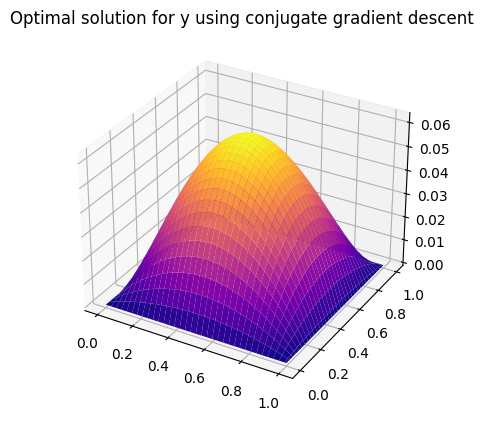

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, y.reshape(N+1,N+1), cmap='plasma')
ax.set_title('Optimal solution for y using conjugate gradient descent')
plt.savefig('cgd_y.png')
plt.show()

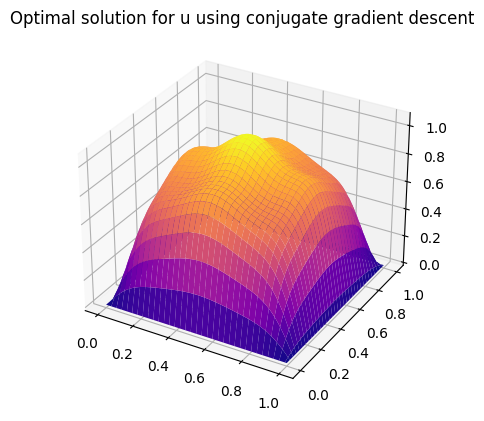

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, u.reshape(N+1,N+1), cmap='plasma')
ax.set_title('Optimal solution for u using conjugate gradient descent')
plt.savefig('cgd_u.png')
plt.show()

In [23]:
print(iteration,residual)

2 2.667019325852138e-07
